# 数据探索性分析与数据预处理

# 0.引入需要的三方库

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1.查看竞赛提供的所有文件

In [3]:
os.listdir('./data/preliminary_contest_data/')

['adFeature.csv',
 'adFeature.csv.baiduyun.uploading.cfg',
 'test1.csv',
 'test1.csv.baiduyun.uploading.cfg',
 'test1_truth.csv',
 'test1_truth.csv.baiduyun.uploading.cfg',
 'train.csv',
 'train.csv.baiduyun.uploading.cfg',
 'userFeature.csv',
 'userFeature.csv.baiduyun.uploading.cfg',
 'userFeature.data',
 'userFeature.data.baiduyun.uploading.cfg']

# 2.训练集与测试集

In [4]:
train = pd.read_csv('data/preliminary_contest_data/train.csv')
test1 =  pd.read_csv('data/preliminary_contest_data/test1.csv')
test1_truth = pd.read_csv('data/preliminary_contest_data/test1_truth.csv', header=None)
test1_truth.columns  = train.columns
print(train.shape, test1.shape, test1_truth.shape)

(8798814, 3) (2265989, 2) (2265989, 3)


In [5]:
train.head().to_csv("temp/train_head.csv", index=False)
train.tail().to_csv("temp/train_tail.csv", index=False)

In [6]:
test1.head().to_csv("temp/test1_head.csv", index=False)
test1.tail().to_csv("temp/test1_tail.csv", index=False)

In [7]:
test1_truth.head().to_csv("temp/test1_truth_head.csv", index=False)
test1_truth.tail().to_csv("temp/test1_truth_tail.csv", index=False)

In [8]:
# 可以看到腾讯公开提供的数据集中给出了测试集的真实标签，参赛者需要明确这是一个双主键的
# 用户与广告匹配，因此可以适当查看训练集与测试集的aid与uid的重叠情况。

In [10]:
# 检查缺失情况
assert train.isnull().sum().sum() == 0
assert test1.isnull().sum().sum() == 0
assert test1_truth.isnull().sum().sum() == 0
print((train['label']==1).astype(int).mean())

0.047956576875019745


In [9]:
# 检查训练集与测试集的uid与aid重合情况
def check_duplicate(feature):
    print('duplicate check of ' + feature)
    train_unique = train[feature].unique().tolist()
    test1_unique = test1[feature].unique().tolist()
    all_unique = list(set(train_unique + test1_unique))
    print('train_unique', len(train_unique))
    print('test1_unique', len(test1_unique))
    print('all_unique', len(all_unique))
    print('duplicate', len(train_unique) + len(test1_unique) - len(all_unique))
    print('\n')
    return 
check_duplicate('uid')
check_duplicate('aid')
# 结论：可以看出测试集的用户只有不到18%出现在训练集中，而aid与训练集中出现的全部一样

duplicate check of uid
train_unique 7883466
test1_unique 2195951
all_unique 9686953
duplicate 392464


duplicate check of aid
train_unique 173
test1_unique 173
all_unique 173
duplicate 173




In [10]:
# 检查训练集与测试集的双主键重合情况
train_nunique = train[['uid', 'aid']].drop_duplicates().shape[0]
test1_nunique = test1[['uid', 'aid']].drop_duplicates().shape[0]
all_nunique = test1[['uid', 'aid']].append(train[['uid', 'aid']]).drop_duplicates().shape[0]
assert train_nunique == train.shape[0]
assert test1_nunique == test1.shape[0]
assert train_nunique + test1_nunique == all_nunique

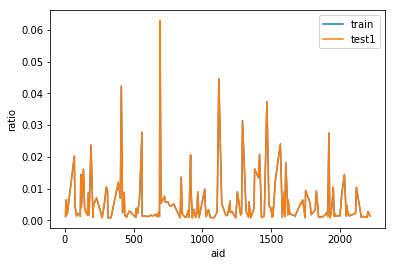

In [11]:
# 分析测试集与训练集中aid的分布差异
(train['aid'].value_counts()/train.shape[0]).sort_index().plot()
(test1['aid'].value_counts()/test1.shape[0]).sort_index().plot()
plt.xlabel('aid')
plt.legend(['train','test1'])
plt.ylabel('ratio')
plt.show()
# 结论：由此可猜测测试集与训练集同分布

# 3.广告属性

In [13]:
# 可以看出这数据结构很简单，给出了每个aid的类别信息
ad = pd.read_csv('data/preliminary_contest_data/adFeature.csv')
ad.head().to_csv('preprocess/ad_head.csv', index=False)

In [15]:
ad.head()

,aid,advertiserId,campaignId,creativeId,creativeSize,adCategoryId,productId,productType
0,2169,16770,38402,43877,35,89,9760,9
1,411,9106,163120,220179,79,21,0,4
2,894,452,38391,43862,35,10,12193,11
3,450,45705,352827,565415,42,67,0,4
4,313,243,531344,979528,22,27,113,9


In [16]:
ad.nunique()

aid             173
advertiserId     79
campaignId      138
creativeId      173
creativeSize     15
adCategoryId     40
productId        33
productType       4
dtype: int64

# 4.用户信息

In [17]:
# 由于数据文件格式为.data，不利于分析统计，因此先将其转换为csv格式的文件，此处转换代码来自开源
# https://github.com/liupengsay/2018-Tencent-social-advertising-algorithm-contest

##读取数据
print("Reading...")
ad_feature=pd.read_csv('data/preliminary_contest_data/adFeature.csv')
if os.path.exists('data/preliminary_contest_data/userFeature.csv'):
    user_feature = pd.read_csv('data/preliminary_contest_data/userFeature.csv')
    print('User feature prepared')
else:
    userFeature_data = []
    with open('data/preliminary_contest_data/userFeature.data', 'r') as f:
        for i, line in enumerate(f):
            line = line.strip().split('|')
            userFeature_dict = {}
            for each in line:
                each_list = each.split(' ')
                userFeature_dict[each_list[0]] = ' '.join(each_list[1:])
            userFeature_data.append(userFeature_dict)
            if i % 1000000 == 0:
                print(i)
        user_feature = pd.DataFrame(userFeature_data)
        print('User feature...')
        user_feature.to_csv('data/preliminary_contest_data/userFeature.csv', index=False)
        print('User feature prepared')

Reading...
User feature prepared


In [26]:
cols = user_feature.columns.tolist()[:10]
user_feature.head()[cols].to_csv('preprocess/user_feature_head.csv', index=False)
user_feature.head()[cols]

,uid,age,gender,marriageStatus,education,consumptionAbility,LBS,interest2,interest5,kw2
0,72068206,4,2,10,1,1,317.0,79 6,77 53 109 30 6 59,15215 80808 114283 71854 34525
1,44661871,5,1,11,7,1,458.0,NaN,77 52 100 72 131 37 116 4 79 71 109 8 69 41 6 ...,15571 92783 34154 33457 31671
2,3036658,3,1,11,7,1,682.0,47 22 58 24 79 73 9 46 32 70 20 6 33 50 49 30 ...,100 72 80 131 37 116 108 79 29 8 113 6 132 42 ...,11395 79112 82720 87384 56195
3,77640094,5,2,6 13,7,2,809.0,79 46 6 18 29,72 92 37 116 47 78 71 8 30 50 6 111 27 75 46 3...,846 95597 33055 41919 81422
4,68081558,4,1,10,2,0,774.0,NaN,NaN,9429 114069 97540 77212 114164


In [19]:
user_feature.shape

(11420039, 24)

In [20]:
# 缺失值状况
user_feature.isnull().sum()

# 其余还可以分析下用户的信息分布，如年龄、性别、学历、消费能力等

uid                          0
age                          0
gender                       0
marriageStatus               1
education                    0
consumptionAbility           0
LBS                         80
interest2              3995451
interest5              2905265
kw2                     418273
topic1                  910265
topic2                  441607
ct                           0
os                           0
carrier                      0
interest1               969798
kw1                    1074371
interest3             11120494
interest4             11250016
kw3                   10899417
topic3                10898167
appIdInstall          11189738
appIdAction           11250466
house                  9330110
dtype: int64

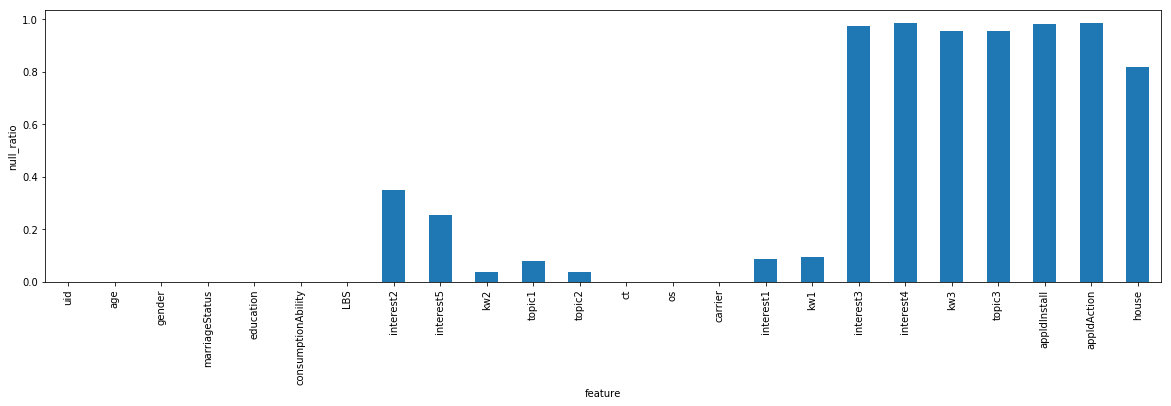

In [24]:
(user_feature.isnull().sum()/user_feature.shape[0]).plot.bar(figsize=(20,5))
plt.xlabel('feature')
plt.ylabel('null_ratio')
plt.show()

In [17]:
# 方便参赛者快速理解并且跑通demo起见，对训练集与测试集进行随机采样，使得大数据问题转换为小数据
train = train.sample(frac=0.01, random_state=2020).reset_index(drop=True)
test1 = test1.sample(frac=0.01, random_state=2020).reset_index(drop=True)
test1['label'] = -2

In [18]:
# 从中取出现有训练集与测试集的用户信息
user_feature = pd.merge(train.append(test1), user_feature, how='left', on='uid').reset_index(drop=True)
user_feature.shape

(110648, 26)

In [19]:
# 拼接广告信息
data = pd.merge(user_feature, ad, how='left', on='aid')
del user_feature

In [20]:
data.shape

(110648, 33)

In [21]:
train.shape

(87988, 3)

In [22]:
test1.shape

(22660, 3)

In [23]:
del train, test1

In [24]:
data['label'].value_counts()

-1    83703
-2    22660
 1     4285
Name: label, dtype: int64

# 5.训练集与测试集特征拼接

In [25]:
# 进行标签的转换，方便区分训练集与测试集
data['label'].replace(-1, 0, inplace=True)
data['label'].replace(-2, -1, inplace=True)
data['label'].value_counts()

 0    83703
-1    22660
 1     4285
Name: label, dtype: int64

In [26]:
# 进行后续需要使用到的训练集、测试集以及测试集标签生成
train = data[data['label']>=0].reset_index(drop=True)
test = data[data['label']==-1].reset_index(drop=True)
del data

In [27]:
test_truth = pd.merge(test[['aid', 'uid']], test1_truth, how='left', on=['aid', 'uid'])
test_truth['label'].replace(-1, 0, inplace=True)

In [28]:
test_truth['label'].value_counts()

0    21584
1     1076
Name: label, dtype: int64

In [30]:
# 根据字段类型划分
cols = train.columns.tolist()
cols.sort()
se = train[cols].dtypes

text_features = se[se=='object'].index.tolist()
discrete_features = se[se!='object'].index.tolist()

discrete_features.remove('aid')
discrete_features.remove('uid')
discrete_features.remove('label')

In [31]:
text_features

['appIdAction',
 'appIdInstall',
 'ct',
 'interest1',
 'interest2',
 'interest3',
 'interest4',
 'interest5',
 'kw1',
 'kw2',
 'kw3',
 'marriageStatus',
 'os',
 'topic1',
 'topic2',
 'topic3']

In [54]:
discrete_features

['LBS',
 'adCategoryId',
 'advertiserId',
 'age',
 'campaignId',
 'carrier',
 'consumptionAbility',
 'creativeId',
 'creativeSize',
 'education',
 'gender',
 'house',
 'productId',
 'productType']

In [55]:
text_features = ['appIdAction', 'appIdInstall', 'ct', 'interest1',
 'interest2', 'interest3', 'interest4', 'interest5', 'kw1',
 'kw2', 'kw3', 'marriageStatus', 'os', 'topic1', 'topic2', 'topic3']

cat_features = ['LBS', 'adCategoryId', 'advertiserId', 'age', 'campaignId',
 'carrier', 'consumptionAbility', 'creativeId', 'creativeSize', 'education',
 'gender', 'house', 'productId', 'productType', 'aid', 'uid']
train[text_features] = train[text_features].fillna('00').astype(str)
test[text_features] = test[text_features].fillna('00').astype(str)
train[cat_features] = train[cat_features].fillna('00').astype(str)
test[cat_features] = test[cat_features].fillna('00').astype(str)

In [57]:
# 将拼接好的表格进行存储
train.to_csv('preprocess/train_sample.csv', index=False)
test.to_csv('preprocess/test_sample.csv', index=False)

test_truth.to_csv('preprocess/test_truth_sample.csv', index=False)

# 6.基本建模思路

In [33]:
# 总结：通过简单的数据探索性分析以及表格的拼接处理，参赛者可以感知到这个数据结构十分清晰，就两类特征，
# 即单变量离散特征discrete_features与多变量文本特征text_features，因此可以考虑直接使用catboost进行建模